## Coding in Stan: the BYM2 model for disconnected graphs

Mitzi Morris

In [A note on intrinsic Conditional Autoregressive models for disconnected graphs](https://arxiv.org/abs/1705.04854), Freni-Sterrantino et.al. show how to implement the BYM2 model for use with areal data where the graph structure of the map is not fully connected.  In this notebook, we present that Stan implementation of this proposal.

#### Required packages

To run this notebook you must have:

- [matplotlib](https://anaconda.org/conda-forge/matplotlib)
- [arviz](https://anaconda.org/conda-forge/arviz)
- [cmdstanpy](https://anaconda.org/conda-forge/cmdstanpy)

### Disease mapping: computing relative risk over a map of geographical regions

Disease mapping concerns the study of disease risk over a map of geographical regions.
For an areal map of $N$ regions, the data consists of
outcome $y_i$, the number of cases of a given disease in region $i$,
and may possibly include observed values of region-specific covariates $x_i$.
The counts $y_i$ are modeled as either Poisson or binomial random variables in generalized linear models,
using a log or logit link function, respectively.
For rare diseases the binomial probability is small and the Poisson model
is used as an approximation.

Counts of rare events in small-population regions are noisy;
removing this noise allows the underlying phenomena of interest to be seen more clearly.
Conditional autoregressive (CAR) models smooth noisy estimates
by pooling information from neighboring regions.
Given an areal map, the binary _neighbor_ relationship
(written $i \sim j$ where $i \neq j$)
is $1$ if regions $n_i$ and $n_j$ are neighbors and is otherwise $0$.
For CAR models, the neighbor relationship is symmetric but not reflexive;
if $i \sim j$ then $j \sim i$, but a region is not its own neighbor.

### The BYM2 model

The BYM2 model is a disease mapping model presented in [Riebler et al. 2016](https://arxiv.org/abs/1601.0118)
with a spatial random effects component parameterized in terms of:

- $\phi$, an ICAR component which accounts for the spatial structure of the data.
- $\theta$, an ordinary random effects component which accounts for non-spatial heterogeneity.
- $\rho$,  a mixing parameter which accounts for the amount of spatial/non-spatial variation.
- $\sigma$, a precision (scale) parameter placed on the combined ICAR and ordinary random effects components.

The mixing parameter $\rho$ is the fraction of spatial *variance*; the amount of non-spatial variance is $1-\rho$.
In order for $\sigma$ to legitimately be the *standard deviation* of the combined components,
it is critical that for each areal unit $i$, the spatial and heterogenious random effects are on the same scale so that $\operatorname{Var}(\phi_i) \approx \operatorname{Var}(\theta_i) \approx 1$. Because $\theta$ is a vector of standard Gaussians, $\operatorname{Var}(\theta_i) \approx 1$ by construction. To scale $\rho$ for the ICAR component $\phi$, the BYM2 model introduces variable $\tau$ (a scaling factor, i.e., a variable, not a parameter):
The combined spatial, non-spatial random effects are:
$$\sigma ((\sqrt{\rho/\tau}\,\phi + \sqrt{1-\rho}\,\theta)$$

Riebler recommends using the geometric mean of the average marginal variance of the elements of $\theta$ as the value of $\tau$.
As the structure of $\rho$ is map-specific, i.e., dependent on the number of regions and number of neighbors of each region, the scaling factor $\tau$ is data-dependent.

The recommended priors are:

- A standard prior on the standard deviation $\sigma$; we use a half-normal, also possible are half-t or an exponential.
- A beta(1/2,1/2) prior on $\rho$.

The Stan case study [Spatial Models in Stan: Intrinsic Auto-Regressive Models for Areal Data](https://mc-stan.org/users/documentation/case-studies/icar_stan.html) provides the background and derivations for the ICAR and the BYM2 model.


### Maps with disconnected components and islands

[GIS (geographic information systems)](https://www.gislounge.com/what-is-gis/)
data encodes the geolocation information for the regions in a map.
Both Python and R provide GIS libraries and plenty of good online resources, e.g.

- [Geocomputation with R](https://geocompr.robinlovelace.net/index.html)
- [Introduction to Python GIS](https://automating-gis-processes.github.io/2016/Lesson1-Intro-Python-GIS.html)

The following two maps are based on a downloads of GIS data from the UK Office for National Statics (ONS) [Open Geography Portal](https://geoportal.statistics.gov.uk) for the [Local Authority Districts](https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-december-2020-uk-bfc/about) (at the lowest shoreline resolution).

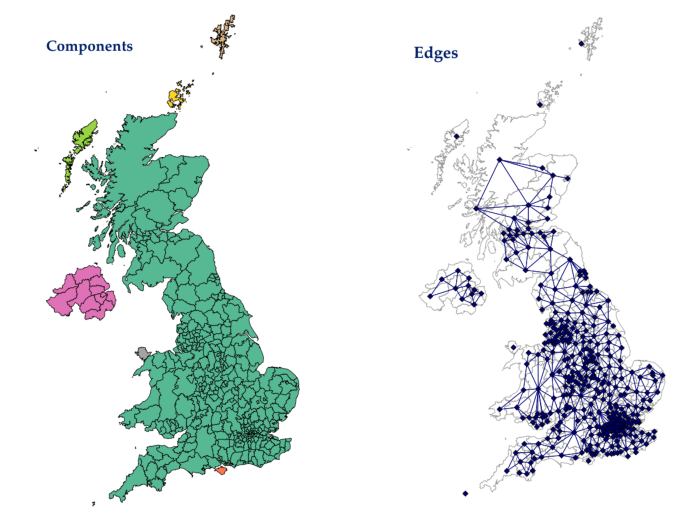

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots(1, 2)
ax[0].axis('off'); ax[1].axis('off')
ax[0].imshow(mpimg.imread('img/uk_components.png'))
ax[1].imshow(mpimg.imread('img/uk_edges.png'))


### Stan implementation of the BYM2 model for a fully connected spatial structure

For the Stan implementation of the ICAR component, we compute the per-node spatial variance by representing the spatial structure of the map as an _edgelist_; a 2D array of size 2 × J where J is the number of edges in the graph. Each column entry in this array represents one undirected edge in the graph, where for each edge j, entries [j,1] and [j,2] index the nodes connected by that edge. Treating these are parallel arrays and using Stan's vectorized operations provides a transparent implementation of the pairwise difference formula used to compute the ICAR component.


When the areal map is a single, fully connected component, i.e., a graph where any node in the graph can be reached from any other node, the BYM2 model is implemented as follows.
The spatial structure and scaling factor are input as data, therefore declared in the model's `data` block:

The spatial and heterogeneous effects, combined variance, and proportion of spatial variance are model parameters, defined in the `parameters` block:

In order to improve the orgnization and readability of the Stan model, we use the `transformed parameters` block to code up the combined spatial and random effects component $\sigma ((\sqrt{\rho/\tau}\,\phi + \sqrt{1-\rho}\,\theta)$ as vector `gamma`:

The likelihood can now be expressed cleanly as:

The spatial effects parameters `phi` has an ICAR prior.  We implement this by defining a log probability density function to compute the ICAR model via the pairwise difference formula.  Because this is an improper prior, we must add a soft sum-to-zero constraint:

### BYM2 model for disconnected graphs

Freni-Sterrantino et al show how to adjust the scaling factors when the areal map is not fully connected but has at least one connected multi-node component.  For a map with $C$ components:

- Each connected component of size > 1 is scaled independently with scaling factor ${\tau}_c$ and a sum-to-zero constraint is imposed on that component

- Components of size 1 are drawn from a standard distribution; i.e., they are treated as having random i.i.d. spatial variance


### Stan implementation of the BYM2 model for disconnected graphs

To extend the BYM2 model to these areal maps, we add a set of indexes for the node and edgelists which we can use to pick out the subgraphs for each component.
The `_cts` arrays record the size of the node and edgelists for each component, the `_idx` arrays provide the indices of the members of each component.
The Stan language's multi-index expression allows for vectorized operations given an array of indices.

The ICAR `_lpdf` function puts a sum-to-zero constraint on each component and singletons have normal (0,1) spatial variance.
The component structure information is passed into the ICAR function.  The per-component loop uses these structures to pick out the set of edge and node indices in that component, and updates the spatial variance parameter `phi` accordingly.

The BYM2 model parameters are the same.  As before, we use the `transformed parameters` block to compute the combined random effect `gamma`.   Now, each component must be scaled by the per-component scaling factor.  To make this computation efficient, in the `transformed data` block, we compute the per-node scaling, based on component membership.

The transformed parameter `gamma` is computed as in the BYM2 model, modulo use of vector `taus` instead of scalar `tau`:

### Stan program data inputs `I`, `J`, `edges`, `tau`

A certain amount of data munging is necessary to assemble the data inputs to the Stan program.

Areal maps, as coded in a modern geographical information systems (GIS), consist of 
a set of regions, where each region is described by polygons over latitude/longitude coordinates.  These are distributed as a structured bundle of tables of information and geolocational coordinates called [shapefiles](https://en.wikipedia.org/wiki/Shapefile). Spatial weights are an abstraction over the geographical relationships in these maps.

- The R package `sf` provides the tools to read in and edit GIS shapefils.
(_Note: the Python library `geopandas` provides similar functionality_).

- The R package `spdep` (_Python library `pysal`_) provides functions to create and manipulate spatial weights
as graphs and/or matrices

- The [igraph](https://igraph.org) libraries for R, Python, and C++ provide functions for graph and network analysis.

- The R package `Matrix` provides functions for sparse matrices.

#### Computing `I`, `J`, `edges`: the number of nodes, edges, and edgelist

The areal graph is described in terms of integers `I` and`J` the number of nodes and edges, respectively, and `edges` the $2 \times J$ integer array of edges, where entries `[1,j]` and `[2,j]` specify neighboring regions.  Given a set of areal shapefiles as inputs, the munging required using the above R libraries is:

1. Read in the shapefiles - R function `sf::st_read`
2. Transform to neighbors list `spdep::poly2nb` - list length is `I`
3. Transform list to adjacency matrix `spdep::nb2mat`, then extract edgelist - R function `igraph::graph_from_adjacency_matrix` - num rows is `J`.
4. Transpose edgelist from $\mathrm{J} \times 2$ matrix to $2 \times \mathrm{J}$ - result is `edges`.

#### Computing `tau`, the ICAR scaling factor

Riebler recommends scaling the ICAR component $\theta$ so the geometric mean of the average marginal variance of the areal units is $1$, in order to make mixing parameter $\rho$ properly interpretable. The steps required for this computation are:

1. compute Q, the precision matrix corresponding to the neighborhood structure of the areal map.  In R, we use packages `Matrix` and `R-INLA` to compute `tau` by creating a `Matrix::sparseMatrix` object from the edgelist `edges` - this is Q.
2. compute Q_pert by adding a small amount of noise to the diagonal elements of Q
3. compute Q_inv, the covariances between all neighbors - **computationally expensive**
4. compute the geometric mean of the diagonal elements of Q_inv, `exp(mean(log(x)))`, this is $\tau$

### Data inputs for disconnected graphs


Using the R `spdep` package functions `n.comp.id` and `subset.nb`, we first create per-component subgraphs and then compute the scaling factor as outlined above.

### Regression data:  the Scotland cancer dataset

The canonical dataset used to test and compare different parameterizations of ICAR models is a study on the incidence of lip cancer in Scotland in the 1970s and 1980s. The data, including the names and coordinates for the counties of Scotland are available from R package SpatialEpi, dataset scotland.

The cancer study data is a set of observations taken from 56 counties in Scotland.  It consists of 3 parallel arrays:

- `y`: observed outcome - number of cases of lip cancer
- `x`: single predictor - percent of population working in agriculture, forestry, or fisheries.
- `E`: population

This data is common to all of the `.data.json` files, also in file `scotland_lip.data.R`.  The Scotland lip cancer data is in many R packages and textbook examples.  The pre
dictor `x` is sometimes called `AFF`; it represents the proportion or percentage of the population employed in agriculture, farming, and fishing.  Sometimes the predictor `x` it is given as a percentage, i.e., scaled from 1 to 100; sometimes as a proportion, scaled from 0 to 1.  However in INLA and some BUGS models, in the regression, this factor is often the population percentage scaled by 1/10.  For the sake of generality, we have not done so.

### Areal data:  the 56 counties of Scotland

The common format for the spatial structure of an areal dataset is as a set of [shapefiles](https://en.wikipedia.org/wiki/Shapefile), a geospatial vector format.  The R package `spdep` provides methods which determines the adjacency relations between spatial polygons and returns a `nb` object which is list over the nodes in the graph, each element of which the list of the indices of neighboring nodes, or `0`, for singleton node.

Three counties in Scotland are islands:  the Hebrides (western.isles), Shetland, and Orkney.  In the Scotland datasets commonly distributed with R packages for CAR models, edges are added to the neighborhood graph so that these islands are adjoined to the mainland, so that the resulting adjacency graph is a single, fully connected component. 

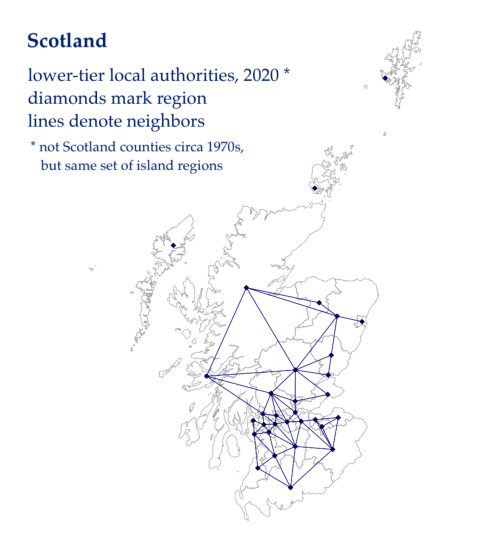

In [2]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = (11,10)
plt.axis('off'); plt.imshow(mpimg.imread('img/scotland_islands.png'))


For the BUGS implementation of the ICAR and BYM models, the spatial structure of the areal map is in the `nb` object format, i.e., a list of lists of node indices.  We have written a set of helper functions which take the nb objects for each graph into the set of data structures needed by the Stan models, these are in file bym2_helpers.R. The helper function `nb_to_edge_array` takes the nb object and returns the 2  ×  J edge array; the helper function `scaling_factor` uses the edge array to compute the geometric mean of the corresponding adjacency matrix, and the helper function `index_components` creates per-component node and edge index arrays, and computes the vector of scaling factors tau.

The `scotland` dataset contains the shapefiles for the counties in Scotland.  The fully connected graph corresponds to the data as distributed.  By editing the `nb` objects, remove the egdes which connect the islands to other regions, resulting in a map with 4 components: the mainland, which is a connected graph, and 3 islands, which are singletons.


The the nodes in the graph which are directly affected by these edits are:  

- 1 _sky-lochalsh_
- 3 _caithnes_
- 5 _ross-cromarty_
- 6 _orkney_
- 8 _shetland_
- 9 _moray_
- 11 _western.isles_
- 12 _sutherland_

### Fitting the BYM2_islands model to Scotland map as mainland component plus islands

To run CmdStanPy, we load the following libraries and packages:

In [3]:
import json
import numpy as np

from cmdstanpy import cmdstan_path, CmdStanModel, install_cmdstan
# install_cmdstan()  # as needed - will install latest release (as needed)

The input data file `scotland_islands.data.json` was produced using R and our helper functions, working from file
file `scotland_islands_nbs.data.R`, which has the spatial structure as a graph with one connected component for the mainland and 3 island (singleton) components. This map has the same nodeset as in the `scotland` dataset, but the neighbors object (file `scotland_nbs.data.R`) has been edited to remove all edges between islands and the mainland or each other.

In [4]:
with open('data/scotland_islands.data.json') as fd:
    islands_data = json.load(fd)

print('num nodes: {}, num edges: {}'.format(islands_data['I'], islands_data['J']))

print('edges: {}'.format(islands_data['edges']))

print('num components: {}\nscaling factors: {}\nnodes per component: {}\n'
      'mainland nodes: {}\n'.format(
        islands_data['K'],
        islands_data['tau'],
        islands_data['K_node_cts'],
        islands_data['K_node_idxs'][0]))

num nodes: 56, num edges: 126
edges: [[1, 1, 1, 2, 2, 3, 4, 4, 4, 5, 5, 5, 7, 7, 7, 7, 9, 9, 9, 9, 10, 10, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 18, 20, 21, 21, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 32, 33, 33, 34, 34, 34, 34, 34, 34, 34, 35, 35, 36, 36, 36, 37, 37, 38, 38, 38, 38, 38, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 44, 44, 45, 46, 46, 47, 47, 47, 48, 49, 49, 49, 51, 52, 55], [5, 9, 19, 7, 10, 12, 18, 20, 28, 12, 13, 19, 10, 13, 16, 17, 17, 19, 23, 29, 16, 22, 17, 19, 31, 32, 35, 25, 29, 50, 17, 21, 22, 29, 19, 29, 20, 28, 33, 55, 56, 55, 29, 50, 29, 34, 36, 37, 39, 27, 30, 31, 44, 47, 48, 55, 56, 26, 29, 29, 42, 43, 31, 32, 55, 33, 45, 34, 43, 50, 38, 42, 44, 45, 56, 32, 35, 46, 47, 35, 45, 56, 39, 40, 42, 43, 51, 52, 54, 37, 46, 37, 39, 41, 41, 46, 42, 44, 49, 51, 54, 40, 41, 41, 49, 52, 46, 49, 53, 43, 51, 48, 49, 56, 47, 53, 48, 49, 53, 49

We use CmdStanPy to compile and fit the model using 

In [5]:
from cmdstanpy import cmdstan_path, CmdStanModel
bym2_islands_model = CmdStanModel(stan_file='stan/bym2_islands.stan')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mitzi/github/StanConnect2021_Biostatistics/talk_1/stan/bym2_islands


In [6]:
print(bym2_islands_model.code())

functions {
  /**
   * Return the log probability density of the specified vector of
   * coefficients under the ICAR model with unit variance, where
   * adjacency is determined by the adjacency array and the spatial
   * structure is a disconnected graph which has at least one
   * connected component.  Each connected component has a
   * soft sum-to-zero constraint.   Singleton nodes have
   * distribution normal(0, 1/sqrt(K))
   *
   * The spatial structure is described by a 2-D adjacency array
   * over the all edges in the areal map and a arrays of the
   * indices of per-component nodes and edges which are used as
   * masks into phi and the adjacency matrix.   Because the Stan
   * language lacks ragged arrays, these are all square matrices,
   * padded out with zeros; additional vectors record the number
   * of nodes and edges in each component.
   *
   * @param phi vector of varying effects
   * @param adjacency parallel arrays of indexes of adjacent elements of phi
   * @pa

We fit the model using the data dictionary `islands_data`, alternatively, one can specify file `scotland_islands.data.json`.  For reproducibility, we specify the seed supplied to the Stan pseudo-random number generator used by the sampler.

In [7]:
bym2_islands_fit = bym2_islands_model.sample(data=islands_data, seed=12345)

INFO:cmdstanpy:sampling: ['/Users/mitzi/github/StanConnect2021_Biostatistics/talk_1/stan/bym2_islands', 'id=1', 'random', 'seed=12345', 'data', 'file=/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/ljrtsq0z.json', 'output', 'file=/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/bym2_islands-20211020183206-1-27roj6b_.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']


chain 2 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:sampling completed


The CmdStanMCMC method `summary` wraps the CmdStan [`stansummary`](https://mc-stan.org/docs/cmdstan-guide/stansummary.html) utility; it returns a pandas DataFrame object, one row per summary output row for the joint log probability density `lp__` and for the values of all variables in the Stan program.

In [8]:
islands_summary = bym2_islands_fit.summary()
islands_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,750.000,0.3000,9.200,730.000,750.00,760.000,930.0,54.0,1.0
alpha,-0.059,0.0015,0.090,-0.210,-0.06,0.087,3800.0,220.0,1.0
beta,1.300,0.0150,0.840,-0.086,1.40,2.700,3200.0,180.0,1.0
rho,0.900,0.0051,0.120,0.640,0.95,1.000,550.0,32.0,1.0
sigma,0.590,0.0029,0.094,0.450,0.58,0.760,1000.0,60.0,1.0
...,...,...,...,...,...,...,...,...,...
y_est[52],1.700,0.0100,0.720,0.780,1.60,3.100,5246.0,302.0,1.0
y_est[53],2.300,0.0120,0.920,1.000,2.20,4.000,5593.0,322.0,1.0
y_est[54],2.900,0.0140,1.000,1.500,2.70,4.700,5168.0,297.0,1.0


The R_hat and N_Eff (number of effective samples) in the summary report indicate that the model has fit the data.  To further check the fit, we run the `diagnose` method, which wraps CmdStan's [`diagnose`](https://mc-stan.org/docs/cmdstan-guide/diagnose.html) utility.

In [9]:
print(bym2_islands_fit.diagnose())

Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/bym2_islands-20211020183206-1-27roj6b_.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/bym2_islands-20211020183206-2-jnlcqddr.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/bym2_islands-20211020183206-3-yl2zb7d9.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/bym2_islands-20211020183206-4-r3cmz5_2.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



The diagnose command detects _potential_ problems by examining the sampler variables (the initial columns of the Stan CSV output file, which have column labels which end in `__`).  For each inference result object, here, a [CmdStanMCMC](https://mc-stan.org/cmdstanpy/api.html#cmdstanmcmc) object, the method `method_variables` returns a dictionary of all method variables.  To check the treedepth, which is an integer output between 1 and sampler configuration argument `max_treedepth`, default 10, we can do a quick summary of the per-draw treedepth counts.

In [10]:
method_vars = bym2_islands_fit.method_variables()
treedepth = np.ravel(method_vars['treedepth__'].astype(int))  # flatten chains
treedepths = np.bincount(treedepth)
for idx, val in enumerate(treedepths):
    if val > 0:
        print(idx, val)

7 994
8 3006


To get the summary statistics for a Stan program variable across all chains, we can access individual rows of the pandas DataFrame object using [`iloc`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html).  Here we examine the estimates for observed outcome `y` for the first 11 nodes in the graph, which includes the three islands and nearest mainland regions.

In [11]:
with open('data/scotland_regions.json') as fd:
    scot_names = json.load(fd)

print("index\tobserved\tname")
for i, item in enumerate(scot_names['county'][:12]):
    print(i+1, '\t', islands_data['y'][i],'\t', item)

row_names = list(islands_summary.index)
y_est_rows = [row_names.index(name) for name in row_names if name.startswith('y_est[')]
print('estimated:\n{}\n'.format(islands_summary.iloc[y_est_rows,:][0:12]))

index	observed	name
1 	 9 	 skye-lochalsh
2 	 39 	 banff-buchan
3 	 11 	 caithness
4 	 9 	 berwickshire
5 	 15 	 ross-cromarty
6 	 8 	 orkney
7 	 26 	 moray
8 	 7 	 shetland
9 	 6 	 lochaber
10 	 20 	 gordon
11 	 13 	 western.isles
12 	 5 	 sutherland
estimated:
           Mean   MCSE  StdDev    5%   50%   95%   N_Eff  N_Eff/s  R_hat
name                                                                    
y_est[1]    6.9  0.031     2.2   3.7   6.6  11.0  5335.0    307.0    1.0
y_est[2]   38.0  0.085     5.9  29.0  38.0  48.0  4719.0    272.0    1.0
y_est[3]   11.0  0.045     3.1   6.3  10.0  16.0  4799.0    276.0    1.0
y_est[4]    6.9  0.032     2.2   3.8   6.6  11.0  4971.0    286.0    1.0
y_est[5]   14.0  0.046     3.3   9.5  14.0  20.0  5022.0    289.0    1.0
y_est[6]    6.1  0.026     2.1   3.3   5.8   9.9  6259.0    360.0    1.0
y_est[7]   25.0  0.066     4.6  18.0  25.0  33.0  4903.0    282.0    1.0
y_est[8]    5.0  0.025     1.9   2.5   4.8   8.3  5381.0    310.0    1.0
y_est[9

### Comparison with fitting the BYM2 model on the connected graph

Following Freni-Sterrantino, we compare these outcomes to the estimates obtained from a fully connected graph where Orkney is connected to Shetland and Shetland and the Hebrides are connected to the mainland, as is generally the case in the Scotland datasets included in various R packages.

In [12]:
from cmdstanpy import cmdstan_path, CmdStanModel, install_cmdstan
# install_cmdstan()  # as needed - will install latest release (as needed)

The dataset `scot_connected.data.json` contains the cancer dataset together with the spatial structure.
The spatial structure is comprised of:

- I: `int<lower = 0> I;  // number of nodes`
- J: `int<lower = 0> J;  // number of edges`
- edges: `int<lower = 1, upper = I> edges[2, J];  // node[1, j] adjacent to node[2, j]`
- tau: `real tau; // scaling factor`

In [13]:
with open('data/scotland_connected.data.json') as fd:
    connected_data = json.load(fd)

bym2_model = CmdStanModel(stan_file='stan/bym2.stan')
bym2_fit = bym2_model.sample(data=connected_data, seed=12345)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mitzi/github/StanConnect2021_Biostatistics/talk_1/stan/bym2
INFO:cmdstanpy:sampling: ['/Users/mitzi/github/StanConnect2021_Biostatistics/talk_1/stan/bym2', 'id=1', 'random', 'seed=12345', 'data', 'file=/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/eyc07qg9.json', 'output', 'file=/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmp_jdaajx5/bym2-20211020183217-1-j8lhqf9f.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']


chain 2 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 1 |          | 00:00 Status

INFO:cmdstanpy:sampling completed


In [14]:
connected_summary = bym2_fit.summary()
connected_summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,750.000,0.2700,8.800,740.000,750.000,770.00,1000.0,79.0,1.0
alpha,-0.017,0.0014,0.088,-0.160,-0.017,0.13,3900.0,300.0,1.0
beta,1.300,0.0140,0.840,-0.092,1.300,2.70,3400.0,260.0,1.0
rho,0.920,0.0037,0.100,0.700,0.960,1.00,760.0,58.0,1.0
sigma,0.570,0.0028,0.090,0.430,0.560,0.72,1100.0,80.0,1.0
...,...,...,...,...,...,...,...,...,...
y_est[52],1.700,0.0074,0.660,0.810,1.600,2.90,7868.0,597.0,1.0
y_est[53],2.300,0.0110,0.860,1.100,2.200,3.90,6194.0,470.0,1.0
y_est[54],2.900,0.0120,1.000,1.500,2.700,4.70,7210.0,547.0,1.0


We compare the different estimates for model parameters `alpha`, `beta`, `rho`, and `sigma` for the connected and disconnected fits:

In [15]:
print('connected\n{}\n\nislands\n{}'.format(connected_summary.iloc[1:5,:], islands_summary.iloc[1:5,:]))

connected
        Mean    MCSE  StdDev     5%    50%   95%   N_Eff  N_Eff/s  R_hat
name                                                                    
alpha -0.017  0.0014   0.088 -0.160 -0.017  0.13  3900.0    300.0    1.0
beta   1.300  0.0140   0.840 -0.092  1.300  2.70  3400.0    260.0    1.0
rho    0.920  0.0037   0.100  0.700  0.960  1.00   760.0     58.0    1.0
sigma  0.570  0.0028   0.090  0.430  0.560  0.72  1100.0     80.0    1.0

islands
        Mean    MCSE  StdDev     5%   50%    95%   N_Eff  N_Eff/s  R_hat
name                                                                    
alpha -0.059  0.0015   0.090 -0.210 -0.06  0.087  3800.0    220.0    1.0
beta   1.300  0.0150   0.840 -0.086  1.40  2.700  3200.0    180.0    1.0
rho    0.900  0.0051   0.120  0.640  0.95  1.000   550.0     32.0    1.0
sigma  0.590  0.0029   0.094  0.450  0.58  0.760  1000.0     60.0    1.0


For the connected and islands graphs, the nodes which have different connectivity are: (1,3,5,6,9,11,12).  To see how this affects the estimates, we look at the differences between the relative risks, using Arviz.

In [24]:
import matplotlib.pyplot as plt
import arviz as az

coords = {"region": np.array(scot_names['county'])}
dims={"phi": ["region"], "eta": ["region"], "theta": ["region"], "gamma":["region"], "y_est":["region"]}

connected_az = az.from_cmdstanpy(posterior=bym2_fit, coords=coords, dims=dims)
islands_az = az.from_cmdstanpy(posterior=bym2_islands_fit, coords=coords, dims=dims)

Freni-Strerrantino Fig 3 shows the results of the INLA implementation on this dataset.

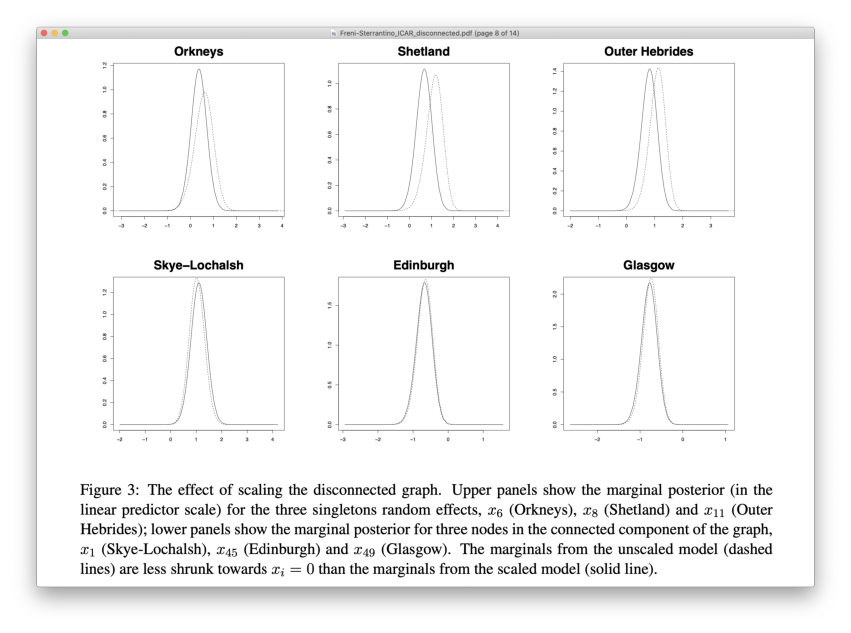

In [25]:
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = (15,15)
plt.axis('off'); plt.imshow(mpimg.imread('img/freni_fig_3.png'))


As the outputs from INLA are not directly comparable to the outputs from Stan, we plot the
density for `gamma`, the combined random effects, for all regions in the map.
The estimates for the connected map, model `bym2`, are shaded in blue and the estimates for the disconnected map, model `bym_islands` are shaded in orange.

In the `bym2_islands` model, the island regions have spatial variance Normal(0, 1).
Without the spatial smoothing imposed by the values of `phi`, which are all close to or greater than $1$, the density plots for `gamma` are located closer to 0.

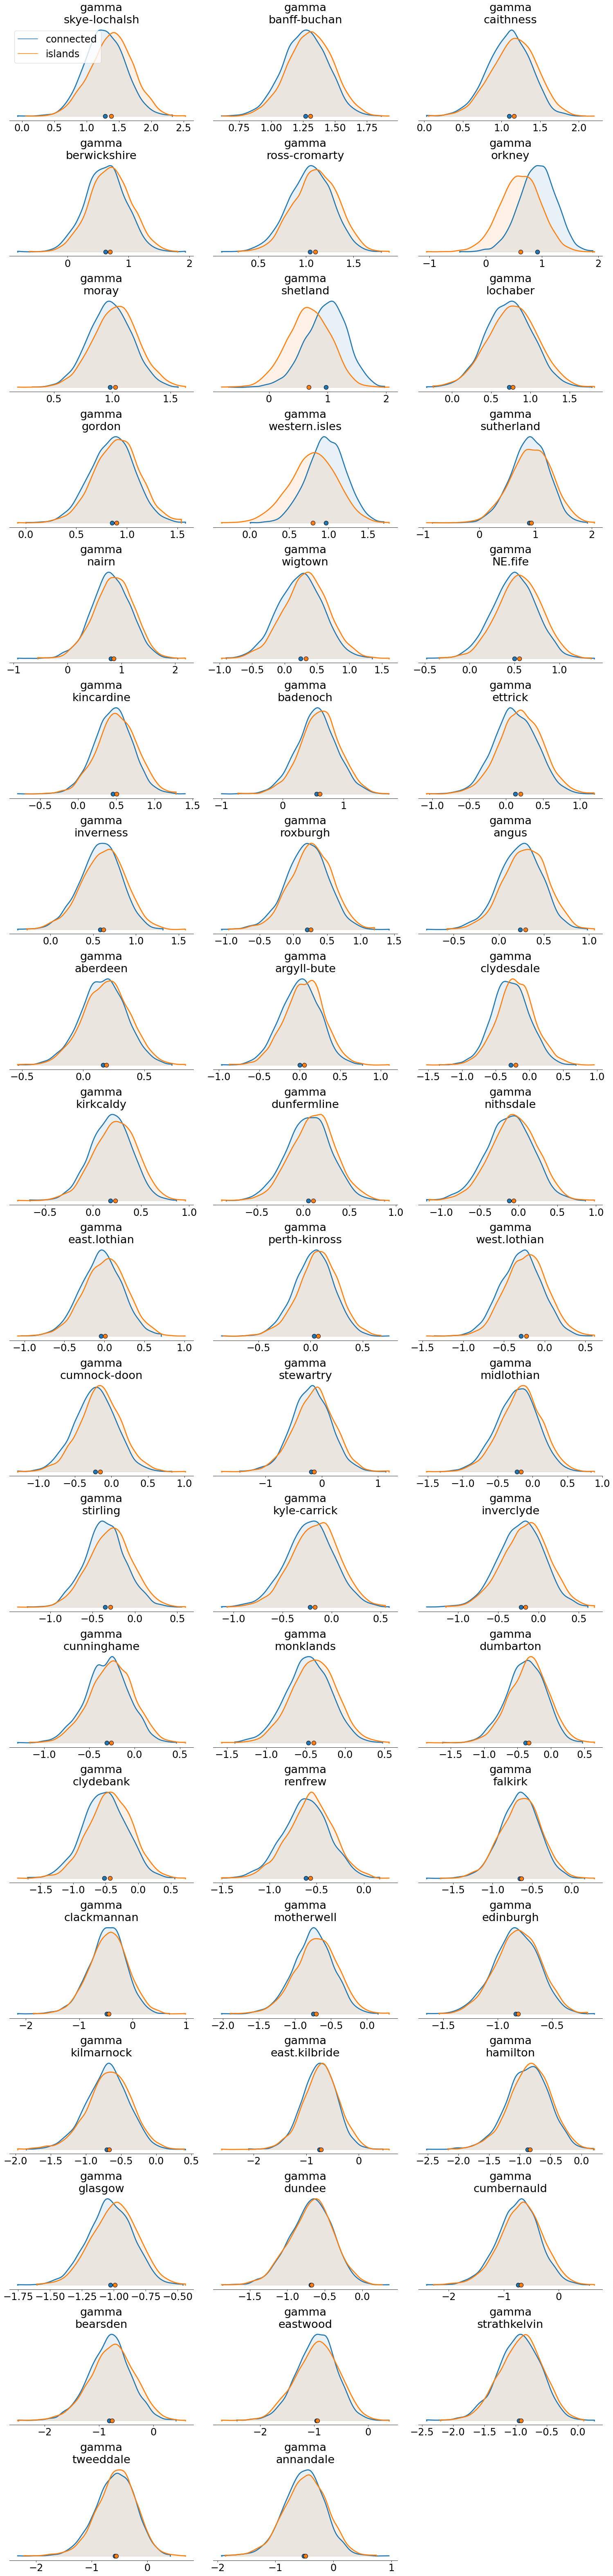

In [30]:
%matplotlib inline
az.rcParams.update({'plot.max_subplots': 100})
az.plot_density(
    [connected_az, islands_az],
    data_labels=['connected', 'islands'],
    var_names=["gamma"],
    shade=0.1,
    textsize=24,
    hdi_prob=0.999999
)
plt.show()